In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [20]:
orgdata = pd.read_csv('House_Rent_Dataset.csv')
data = orgdata.copy()

In [21]:
data.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


<Axes: >

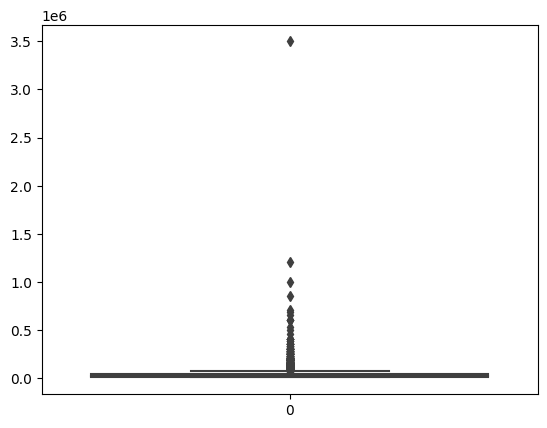

In [22]:
sns.boxplot(data['Rent'])

In [23]:
data.isna().sum()

Posted On           0
BHK                 0
Rent                0
Size                0
Floor               0
Area Type           0
Area Locality       0
City                0
Furnishing          0
Tenant Preferred    0
Bathroom            0
Point of Contact    0
dtype: int64

In [24]:
data = data.drop(data[data['Rent'] == 3500000].index)

<Axes: >

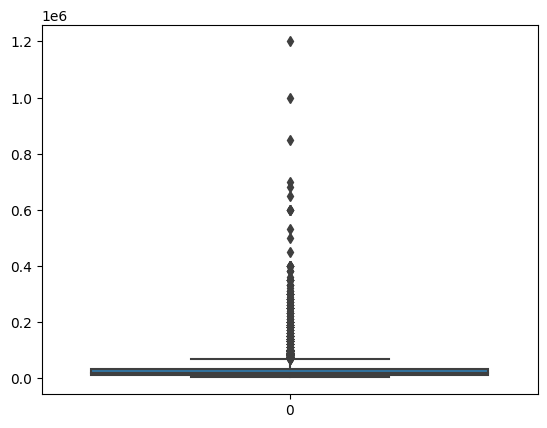

In [25]:
sns.boxplot(data['Rent'])

In [26]:
data.drop(columns=['Area Locality'],inplace=True,axis=1)

In [27]:
data = data.join(data['Floor'].str.split(' out of ', expand=True).rename(columns={0:'Floor Level', 1:'Total Floors'}))
data['Floor Level'] = data.apply(lambda x: 0 if x['Floor Level'] =='Ground' \
                                 else ( -1 if x['Floor Level'] =='Lower Basement' else (x['Total Floors']) ) , axis=1)

data.drop('Floor', axis=1, inplace=True)
data = data.dropna()
data['Floor Level'] = data['Floor Level'].astype(int)
data['Total Floors'] = data['Total Floors'].astype(int)

<Axes: xlabel='Size'>

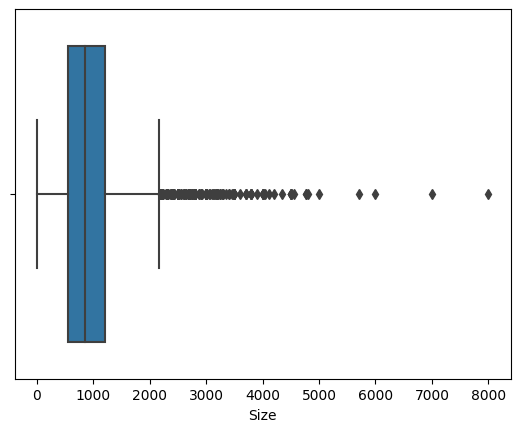

In [28]:
sns.boxplot(x=data['Size'])

In [29]:
data = data[~data['Point of Contact'].str.contains("Contact Builder")]
data = data[~data['Area Type'].str.contains("Built Area")]

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4738 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Posted On         4738 non-null   object
 1   BHK               4738 non-null   int64 
 2   Rent              4738 non-null   int64 
 3   Size              4738 non-null   int64 
 4   Area Type         4738 non-null   object
 5   City              4738 non-null   object
 6   Furnishing        4738 non-null   object
 7   Tenant Preferred  4738 non-null   object
 8   Bathroom          4738 non-null   int64 
 9   Point of Contact  4738 non-null   object
 10  Floor Level       4738 non-null   int64 
 11  Total Floors      4738 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 481.2+ KB


In [31]:
Q1 = np.percentile(data['Size'],25)
Q3 = np.percentile(data['Size'],75)
IQR = Q3-Q1
low = Q1-(1.5*IQR)
high = Q3 +(1.5*IQR) 

In [32]:
high

2175.0

In [33]:
data.drop(data[data['Size']>=high].index,inplace=True)

<Axes: xlabel='BHK'>

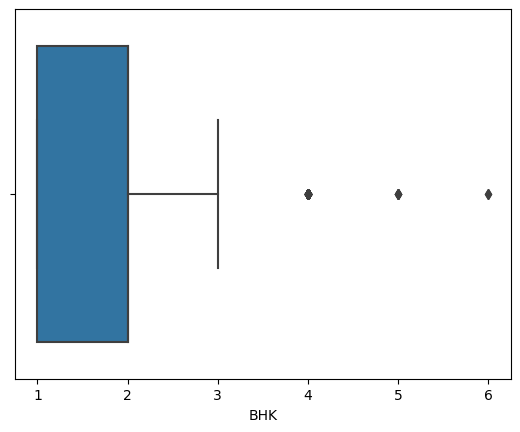

In [34]:
sns.boxplot(x=data['BHK'])

In [35]:
Q1 = np.percentile(data['BHK'],25)
Q3 = np.percentile(data['BHK'],75)
IQR = Q3-Q1
low = Q1 - 1.5*IQR
high = Q3 + 1.5*IQR

In [36]:
data.drop(data[data['BHK'] > high].index,inplace=True)

<Axes: xlabel='Bathroom'>

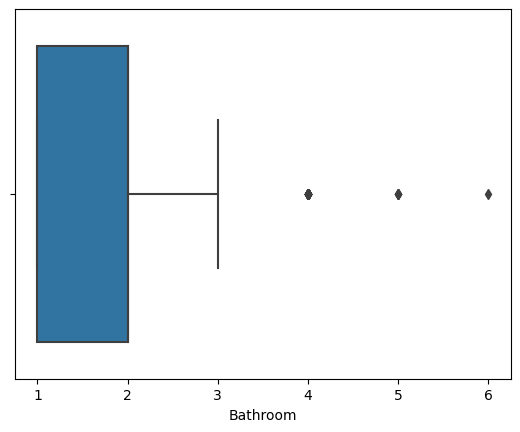

In [37]:
sns.boxplot(x=data['Bathroom'])

In [38]:
Q1 = np.percentile(data['Bathroom'],25)
Q3 = np.percentile(data['Bathroom'],75)
IQR = Q3-Q1
low = Q1 - 1.5*IQR
high = Q3 + 1.5*IQR

In [39]:
data.drop(data[data['Bathroom'] > high].index,inplace=True)

In [40]:
tmp = data[data['Size'] < 120]

In [41]:
data.drop(data[data['Size'] < 120].index,inplace=True)

In [42]:
data.describe()

,BHK,Rent,Size,Bathroom,Floor Level,Total Floors
count,4254.000000,4254.000000,4254.000000,4254.000000,4254.000000,4254.000000
mean,1.961448,25440.907146,881.155148,1.823695,5.808651,6.333098
std,0.697595,31066.054147,411.885603,0.672557,8.209522,7.941667
min,1.000000,1200.000000,120.000000,1.000000,-1.000000,1.000000
25%,1.000000,10000.000000,575.000000,1.000000,2.000000,2.000000
50%,2.000000,15000.000000,800.000000,2.000000,4.000000,4.000000
75%,2.000000,28000.000000,1120.000000,2.000000,5.000000,6.000000
max,3.000000,600000.000000,2170.000000,3.000000,85.000000,85.000000


<Axes: xlabel='Rent', ylabel='Count'>

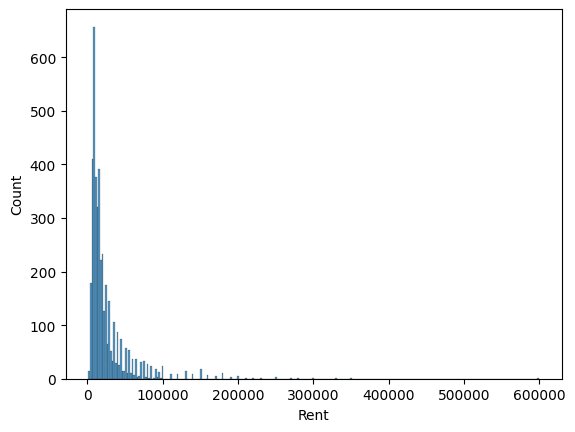

In [43]:
sns.histplot(data['Rent'])

Text(0, 0.5, 'Rent')

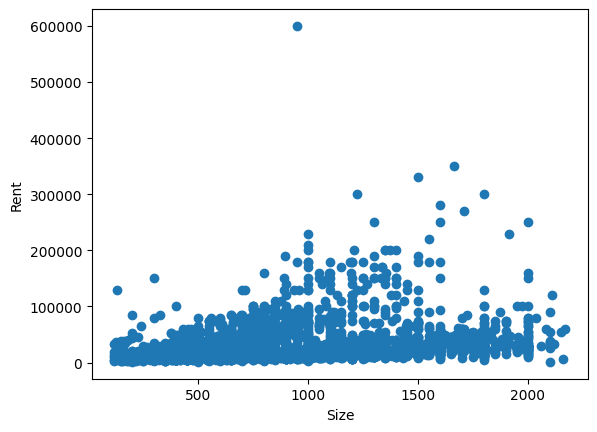

In [44]:
plt.scatter(y=data['Rent'],x=data['Size'])
plt.xlabel('Size')
plt.ylabel('Rent')

Text(0, 0.5, 'Rent')

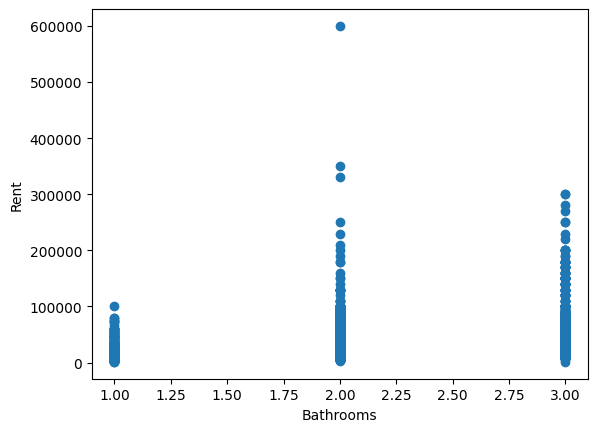

In [45]:
plt.scatter(y=data['Rent'],x=data['Bathroom'])
plt.xlabel('Bathrooms')
plt.ylabel('Rent')

Text(0, 0.5, 'Rent')

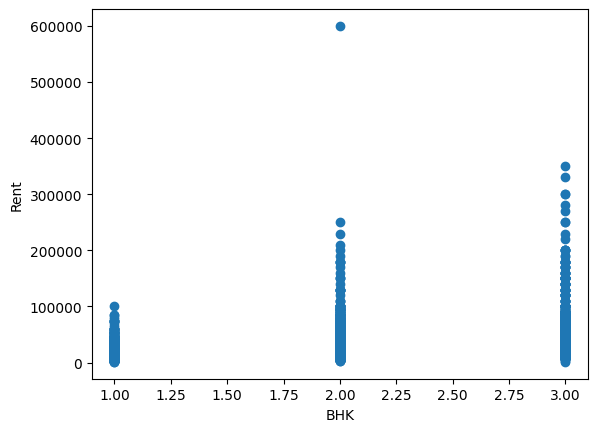

In [46]:
plt.scatter(y=data['Rent'],x=data['BHK'])
plt.xlabel('BHK')
plt.ylabel('Rent')

Text(0, 0.5, 'Rent')

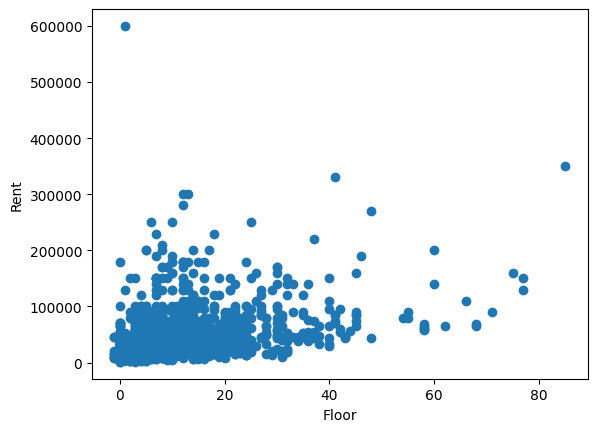

In [47]:
plt.scatter(y=data['Rent'],x=data['Floor Level'])
plt.xlabel('Floor')
plt.ylabel('Rent')

<Axes: xlabel='Rent', ylabel='City'>

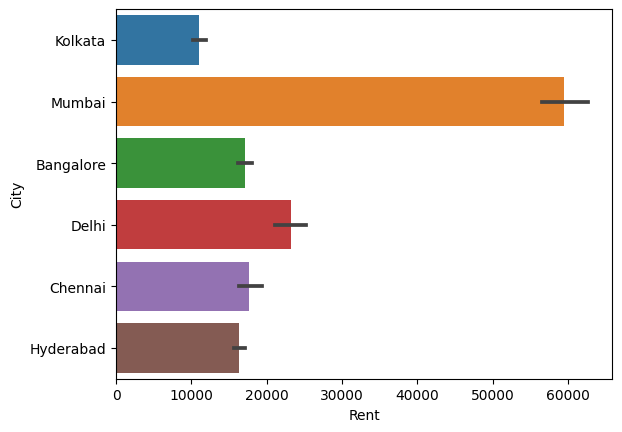

In [48]:
sns.barplot(x=data['Rent'],y=data['City'])

<Axes: xlabel='Rent', ylabel='Furnishing'>

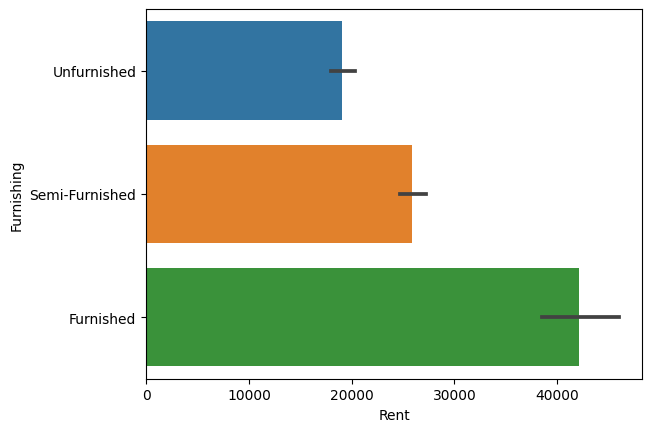

In [49]:
sns.barplot(x=data['Rent'],y=data['Furnishing'])

<Axes: xlabel='Rent', ylabel='Tenant Preferred'>

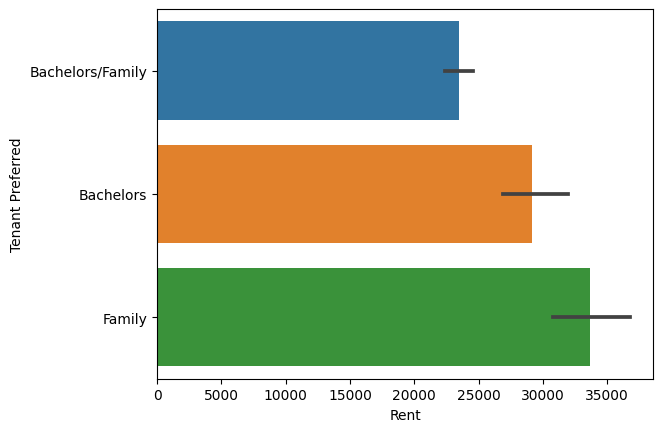

In [50]:
sns.barplot(x=data['Rent'],y=data['Tenant Preferred'])

<Axes: xlabel='Rent', ylabel='Point of Contact'>

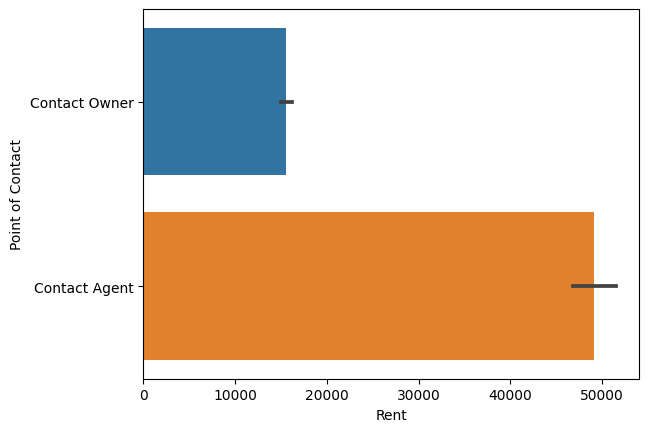

In [51]:
sns.barplot(x=data['Rent'],y=data['Point of Contact'])

<Axes: xlabel='Rent', ylabel='Area Type'>

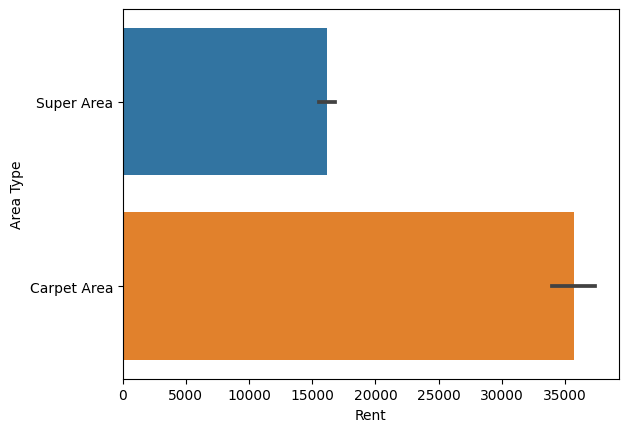

In [52]:
sns.barplot(x=data['Rent'],y=data['Area Type'])

In [53]:
data[data['Rent'] == 600000]

,Posted On,BHK,Rent,Size,Area Type,City,Furnishing,Tenant Preferred,Bathroom,Point of Contact,Floor Level,Total Floors
3656,2022-07-06,2,600000,950,Carpet Area,Chennai,Unfurnished,Bachelors,2,Contact Owner,1,1


In [54]:
data = data.drop(data[data['Rent'] == 600000].index)

In [55]:
print(data['Size'].min())
print(data['Size'].max())
# data['Size'] = boxcox(data['Size'])[0]
# lam_Size = boxcox(data['Size'])[0]

120
2170


In [56]:
data['Posted On'] = pd.to_datetime(data['Posted On'])
data['month posted'] = data['Posted On'].dt.month
data['day posted'] = data['Posted On'].dt.day
data['day of week posted'] = data['Posted On'].dt.day_of_week
data['quarter poster'] = data['Posted On'].dt.quarter

data.drop('Posted On', axis = 1, inplace= True)

In [57]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4253 entries, 0 to 4745
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   BHK                 4253 non-null   int64 
 1   Rent                4253 non-null   int64 
 2   Size                4253 non-null   int64 
 3   Area Type           4253 non-null   object
 4   City                4253 non-null   object
 5   Furnishing          4253 non-null   object
 6   Tenant Preferred    4253 non-null   object
 7   Bathroom            4253 non-null   int64 
 8   Point of Contact    4253 non-null   object
 9   Floor Level         4253 non-null   int64 
 10  Total Floors        4253 non-null   int64 
 11  month posted        4253 non-null   int32 
 12  day posted          4253 non-null   int32 
 13  day of week posted  4253 non-null   int32 
 14  quarter poster      4253 non-null   int32 
dtypes: int32(4), int64(6), object(5)
memory usage: 465.2+ KB


In [58]:
def one_hot_encode(data, column):
    encoded = pd.get_dummies(data[column], drop_first= True)
    data = data.drop(column, axis = 1)
    data = data.join(encoded)
    return data

In [59]:
columns = ['Area Type', 'City', 'Furnishing', 'Tenant Preferred', 'Point of Contact']
for col in columns:
    data = one_hot_encode(data, col)

In [60]:
data.describe()

,BHK,Rent,Size,Bathroom,Floor Level,Total Floors,month posted,day posted,day of week posted,quarter poster
count,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000
mean,1.961439,25305.812133,881.138961,1.823654,5.809781,6.334352,5.747472,15.478251,2.926875,2.198918
std,0.697677,29793.793270,411.932681,0.672631,8.210156,7.942179,0.825394,9.143407,1.833257,0.399233
min,1.000000,1200.000000,120.000000,1.000000,-1.000000,1.000000,4.000000,1.000000,0.000000,2.000000
25%,1.000000,10000.000000,575.000000,1.000000,2.000000,2.000000,5.000000,7.000000,2.000000,2.000000
50%,2.000000,15000.000000,800.000000,2.000000,4.000000,4.000000,6.000000,14.000000,3.000000,2.000000
75%,2.000000,28000.000000,1120.000000,2.000000,5.000000,6.000000,6.000000,23.000000,4.000000,2.000000
max,3.000000,350000.000000,2170.000000,3.000000,85.000000,85.000000,7.000000,31.000000,6.000000,3.000000


In [61]:
data.head()

,BHK,Rent,Size,Bathroom,Floor Level,Total Floors,month posted,day posted,day of week posted,quarter poster,...,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Semi-Furnished,Unfurnished,Bachelors/Family,Family,Contact Owner
0,2,10000,1100,2,0,2,5,18,2,2,...,False,False,False,True,False,False,True,True,False,True
1,2,20000,800,1,3,3,5,13,4,2,...,False,False,False,True,False,True,False,True,False,True
2,2,17000,1000,1,3,3,5,16,0,2,...,False,False,False,True,False,True,False,True,False,True
3,2,10000,800,1,2,2,7,4,0,3,...,False,False,False,True,False,False,True,True,False,True
4,2,7500,850,1,2,2,5,9,0,2,...,False,False,False,True,False,False,True,False,False,True


In [62]:
tmp = data.corr()['Rent']

In [63]:
tmp = tmp.sort_values()

<Axes: >

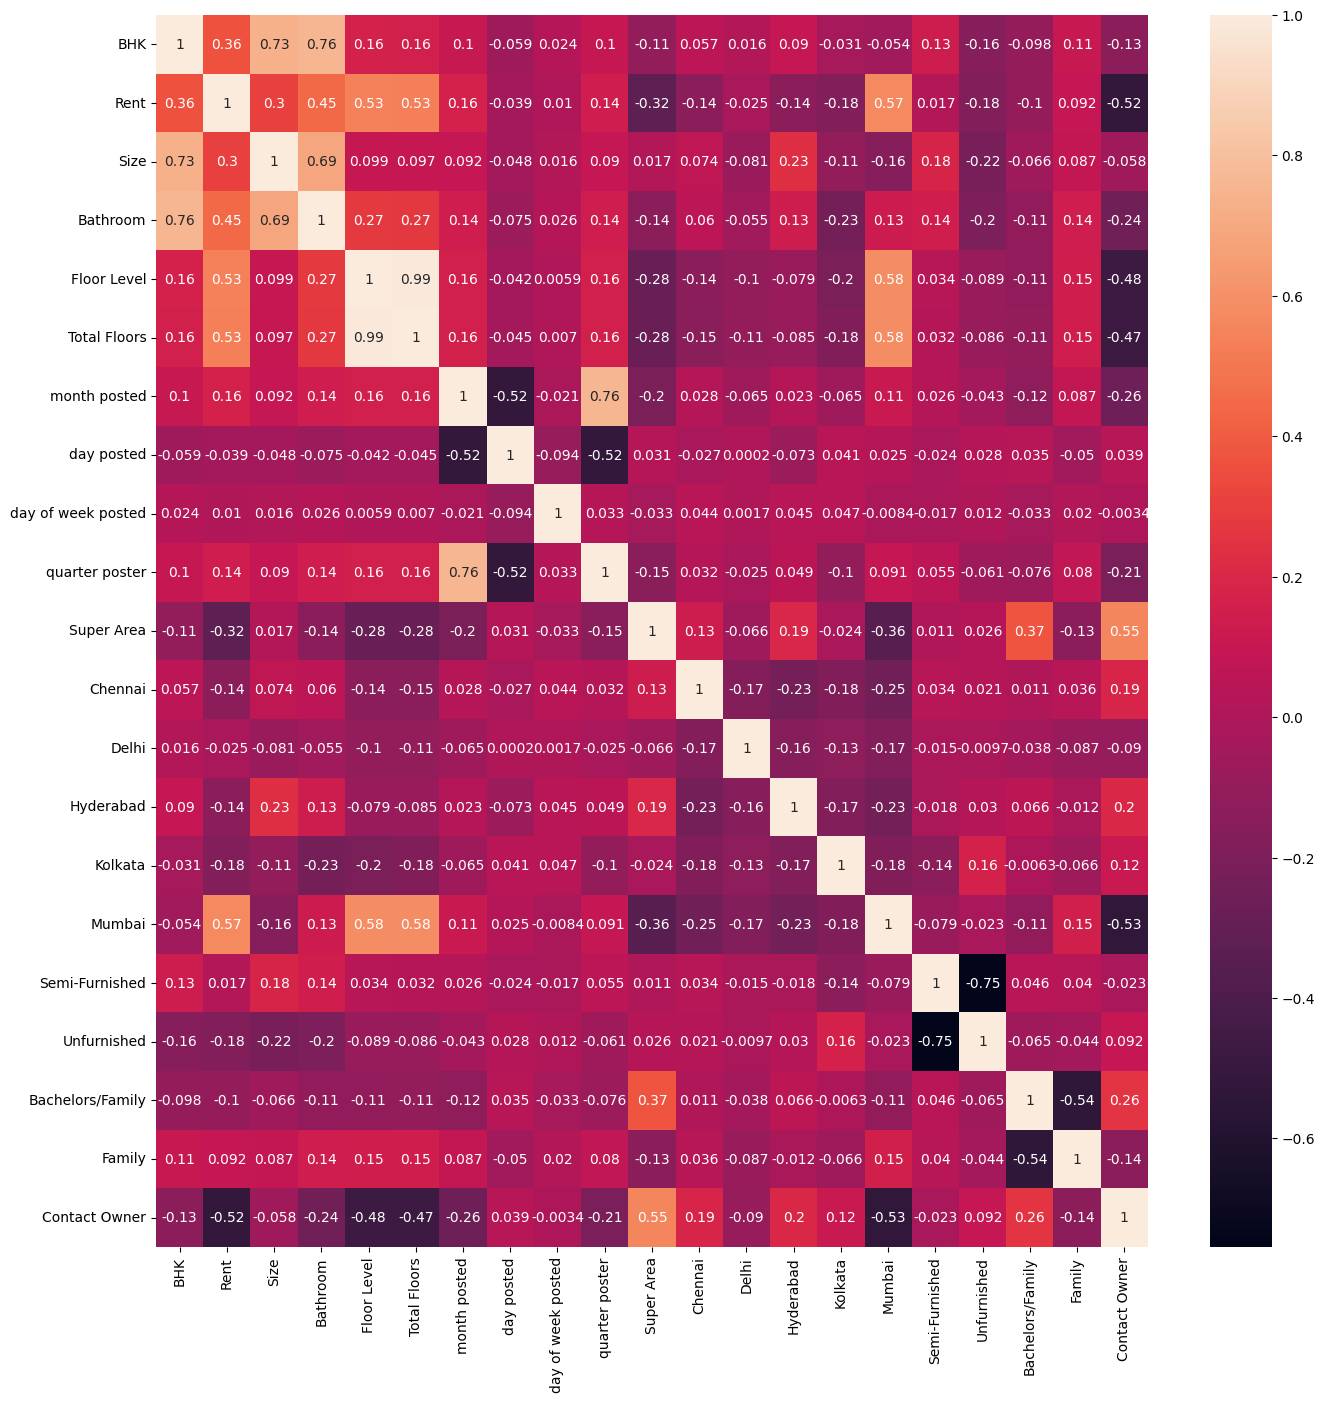

In [64]:
plt.figure(figsize=(16,16))
sns.heatmap(data.corr(),annot=True)

In [65]:
tmp

Contact Owner        -0.517189
Super Area           -0.323313
Unfurnished          -0.178437
Kolkata              -0.175856
Hyderabad            -0.140777
Chennai              -0.139231
Bachelors/Family     -0.101730
day posted           -0.038531
Delhi                -0.024629
day of week posted    0.010261
Semi-Furnished        0.017153
Family                0.091676
quarter poster        0.139105
month posted          0.164219
Size                  0.297720
BHK                   0.364778
Bathroom              0.447619
Total Floors          0.531403
Floor Level           0.534185
Mumbai                0.572608
Rent                  1.000000
Name: Rent, dtype: float64

<Axes: >

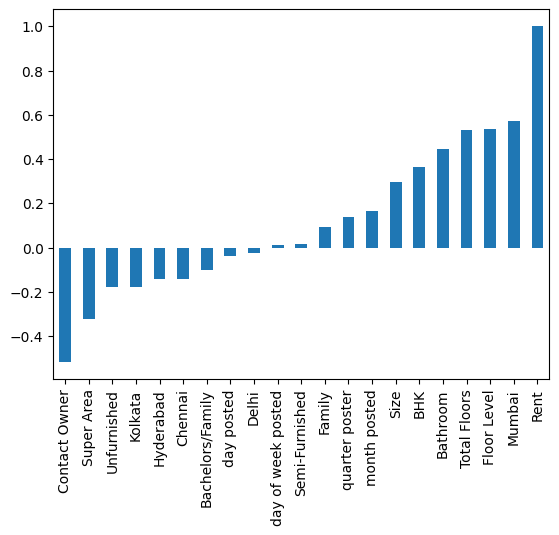

In [66]:
tmp.plot.bar()

In [67]:


x = data[['Contact Owner','Floor Level','Mumbai','Bathroom','BHK','Size','Super Area']]
y = data['Rent']

bc_result = boxcox(y)
y_boxcox = bc_result[0]
lam = bc_result[1]

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state = 42)
x_train, x_test, y_train, y_test = train_test_split(x, y_boxcox, test_size= 0.2, random_state = 42)
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
# y_train = sc.fit_transform(y_train)
# y_test = sc.transform(y_test)

In [68]:
type(x_test)

numpy.ndarray

In [69]:
x_test[0]

array([ 0.64522844, -0.34686566, -0.49521872,  0.24828191,  0.04779252,
        0.27679567,  0.94562643])

In [70]:
lam

-0.297859738284799

In [71]:
y_boxcox.max()

3.28235872332456

In [72]:
y_boxcox.min()

2.951006173647676

In [73]:
models = {
    'random forest' : RandomForestRegressor(),
    'support vector': SVR(),
    'decision tree' : DecisionTreeRegressor(),
    'linear regression' : LinearRegression()
}

In [74]:
for name, model in models.items():
    model.fit(x_train, y_train)
    print(f'{name} trained')

random forest trained
support vector trained
decision tree trained
linear regression trained


In [75]:
results = {}
kf = KFold(n_splits= 10)

for name, model in models.items():
    result = np.mean(np.sqrt(-cross_val_score(model, x_train, y_train, scoring = 'neg_mean_squared_error', cv= kf)))
    results[name] = result

In [76]:
results2 = {}
kf = KFold(n_splits= 10)

for name, model in models.items():
    result = np.mean(np.sqrt(-cross_val_score(model, x_test, y_test, scoring = 'neg_mean_squared_error', cv= kf)))
    results2[name] = result

In [77]:
for name, result in results.items():
    print(f"{name} : {round(result, 5)}")

random forest : 0.02403
support vector : 0.03613
decision tree : 0.02843
linear regression : 0.02293


In [78]:
for name, result in results2.items():
    print(f"{name} : {round(result, 5)}")

random forest : 0.02426
support vector : 0.03815
decision tree : 0.02838
linear regression : 0.02296


In [79]:
results_df = pd.DataFrame(results2, index=range(0,1)).T.rename(columns={0: 'RMSE'}).sort_values('RMSE', ascending=False)
results_df.T

,support vector,decision tree,random forest,linear regression
RMSE,0.038146,0.028378,0.024264,0.022963


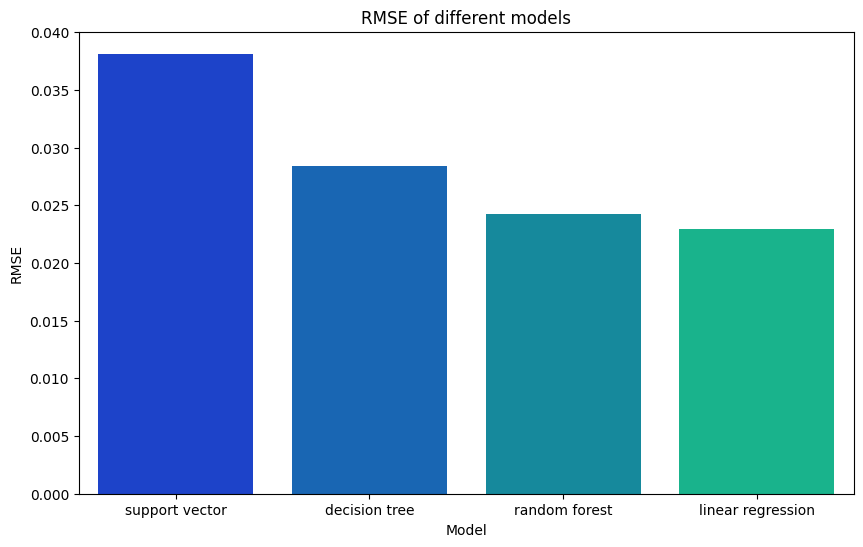

In [80]:
plt.figure(figsize = (10, 6))
sns.barplot(x= results_df.index, y = results_df['RMSE'], palette = 'winter')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of different models');

In [81]:
# final_predictions = inv_boxcox(models['linear regression'].predict(x_test), lam)
train_predictions = models['linear regression'].predict(x_train)
final_predictions = models['linear regression'].predict(x_test)

In [82]:
# print(f'RMSE: {mean_squared_error((y_test), final_predictions)}')
# print(f'R-square: {r2_score(y_test, final_predictions)}')
print(f'RMSE Train: {np.sqrt(mean_squared_error(inv_boxcox(y_train, lam), inv_boxcox(train_predictions,lam)))}')
print(f'RMSE Test: {np.sqrt(mean_squared_error(inv_boxcox(y_test, lam), inv_boxcox(final_predictions,lam)))}')
print(f'R-square Train: {r2_score(inv_boxcox(y_train, lam), inv_boxcox(train_predictions,lam))}')
print(f'R-square Test: {r2_score(inv_boxcox(y_test, lam), inv_boxcox(final_predictions,lam))}')
print(f'MAE Train: {mean_absolute_error(inv_boxcox(y_train, lam), inv_boxcox(train_predictions,lam))}')
print(f'MAE Test: {mean_absolute_error(inv_boxcox(y_test, lam), inv_boxcox(final_predictions,lam))}')

RMSE Train: 17929.176507598422
RMSE Test: 16525.270973207407
R-square Train: 0.636498214576262
R-square Test: 0.6963541474098607
MAE Train: 8416.898462119434
MAE Test: 8087.924934897941


In [83]:
print(f'RMSE Train: {np.sqrt(mean_squared_error(y_train, train_predictions))}')
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, final_predictions))}')
print(f'R-square Train: {r2_score(y_train, train_predictions)}')
print(f'R-square Test: {r2_score(y_test, final_predictions)}')
print(f'MAE Train: {mean_absolute_error(y_train,train_predictions)}')
print(f'MAE Test: {mean_absolute_error(y_test, final_predictions)}')

RMSE Train: 0.02293460099567872
RMSE Test: 0.022848678492077248
R-square Train: 0.7056693485267884
R-square Test: 0.7030121473559333
MAE Train: 0.01714691741611272
MAE Test: 0.017350489579190942


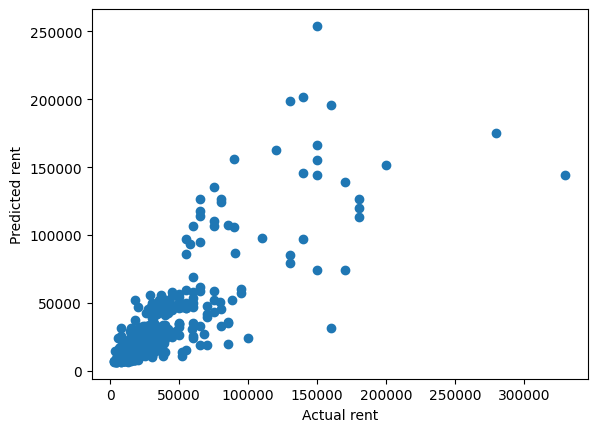

In [84]:
# plt.figure(figsize= (10, 6))
# sns.scatterplot(x= y_test, y= final_predictions, color= '#005b96')
# plt.xlabel('Actual rent')
# plt.ylabel('Predicted rent')
# plt.show()
# plt.figure(figsize= (10, 6))
# sns.scatterplot(x= y_test, y= final_predictions, color= '#005b96')
plt.scatter(x= inv_boxcox(y_test, lam), y= inv_boxcox(final_predictions,lam))
# plt.scatter(x= inv_boxcox(y_train, lam), y= inv_boxcox(models['random forest'].predict(x_train), lam), color= 'blue')
plt.xlabel('Actual rent')
plt.ylabel('Predicted rent')
plt.show()

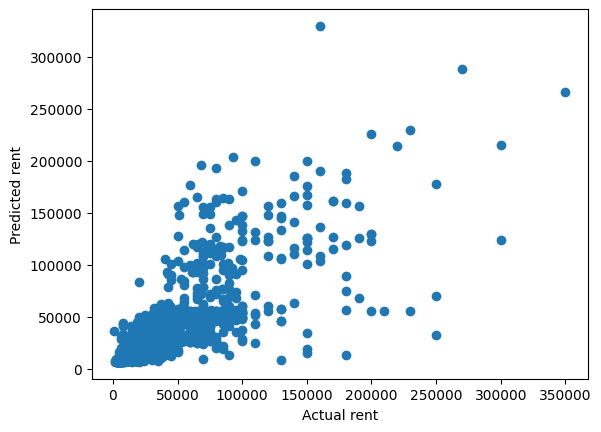

In [85]:
plt.scatter(x= inv_boxcox(y_train, lam), y= inv_boxcox(train_predictions,lam))
# plt.scatter(x= inv_boxcox(y_train, lam), y= inv_boxcox(models['random forest'].predict(x_train), lam), color= 'blue')
plt.xlabel('Actual rent')
plt.ylabel('Predicted rent')
plt.show()

In [86]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5)
lasso.fit(x_train, y_train)
important_variables = x.columns[lasso.coef_ != 0]
print(important_variables)

# Refit model with selected variables
selected_model = LinearRegression()
selected_model.fit(x_train, y_train)

# Evaluate updated model
y_pred_selected = selected_model.predict(x_test)
selected_mse = mean_squared_error(y_test, y_pred_selected,squared=False)

print(selected_mse)

Index(['Contact Owner', 'Floor Level', 'Mumbai', 'Bathroom', 'BHK', 'Size',
       'Super Area'],
      dtype='object')
0.022848678492077248


In [87]:
pd.DataFrame(inv_boxcox(final_predictions,lam))
# final_predictions

,0
0,12948.971628
1,15625.467824
2,15400.027575
3,13500.724001
4,57627.703513
...,...
846,16224.764551
847,26181.956504
848,13949.911419
849,7735.907463


In [88]:
pd.DataFrame(inv_boxcox(y_test,lam))
# y_test

,0
0,12000.0
1,16000.0
2,28000.0
3,24000.0
4,95000.0
...,...
846,35000.0
847,20000.0
848,20000.0
849,10000.0


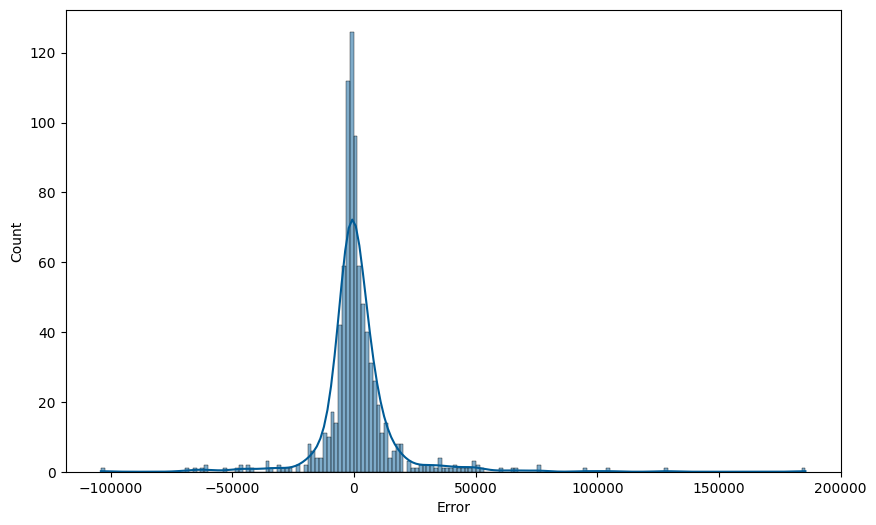

In [89]:
# # Distribution of error
# plt.figure(figsize = (10, 6))

# plt.xlabel('Error');
# Distribution of error
plt.figure(figsize = (10, 6))
# sns.histplot(y_test - final_predictions, color = '#005b96', kde= True)
sns.histplot(inv_boxcox(y_test, lam)-inv_boxcox(final_predictions,lam), color = '#005b96', kde= True)
plt.xlabel('Error');

In [90]:
import pickle

# create a model object
filename = 'model.pkl'
pickle.dump(models['linear regression'], open(filename, 'wb'))

In [91]:
# import pickle

# class MyModel:
#     def __init__(self, model, lambda_value):
#         self.model = model
#         self.lambda_value = lambda_value

# my_model_object = MyModel(model=models['linear regression'], lambda_value=lam)
# with open('my_model.pkl', 'wb') as f:
#     pickle.dump(my_model_object, f)
